# Import dependencies, API key and set output file name

In [9]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime
import os
import gmaps
import seaborn as sn

# Import API key from a file that is ignored by Git (.gitignore file) so the key isn't exposed to the public
from config import gkey

# Configure gmaps
gmaps.configure(api_key=gkey)

## Store County Health Rankings Excel file results into DataFrame

* Load the excel file imported from https://www.countyhealthrankings.org/app/texas/2019/measure/outcomes/144/description?sort=desc-2

In [2]:
add_df = pd.read_excel('data/2019c.xls',  sheet_name='Additional Measure Data')
rmd_df = pd.read_excel('data/2019c.xls', sheet_name='RMD')

add_df.head()

,FIPS,State,County,lifeExpect,prematureAAMortalityNum,childMortalityRate,infantMortalityRate,freqPhysDistressPerct,freqMentalDistressPerct,diabeticPerct,...,popOver65Perct,popBlackPerct,popNativePerct,popAsianPerct,popHawaiinIslanderPerct,popHispPerct,popNonHispWhitePerct,popNoEnglishPerct,popFemalePerct,popRuralPerct
0,48001,Texas,Anderson,73.773772,544.0,46.941011,NaN,12.117431,11.455405,10.7,...,14.535599,20.687207,0.677162,0.900573,0.143745,17.815763,59.126098,2.715874,39.067560,67.063533
1,48003,Texas,Andrews,76.756795,398.9,NaN,NaN,10.211176,9.869883,8.6,...,10.534928,1.388105,1.467103,0.750480,0.022571,56.190046,40.238122,7.408334,49.035098,16.502097
2,48005,Texas,Angelina,76.336820,454.5,55.887349,5.491937,13.030222,12.570179,13.6,...,15.791811,14.786174,0.753943,1.165082,0.063778,22.179830,60.661694,4.471560,51.333068,43.082366
3,48007,Texas,Aransas,76.912561,470.0,NaN,NaN,12.065267,11.894536,13.7,...,27.295479,1.360863,1.243548,1.931800,0.082121,27.655248,67.171125,1.588916,50.527921,27.260558
4,48009,Texas,Archer,77.039463,409.4,NaN,NaN,9.686461,10.443107,11.3,...,19.888750,0.760586,1.419003,0.431377,0.034056,8.684300,88.023612,0.823881,50.448405,88.988292


In [3]:
merged_df = pd.merge(rmd_df,add_df, how='inner', on='County')
cols = merged_df.columns
col_list = [col for col in cols]
merged_df.head()

,FIPS_x,State_x,County,UrbanRural,yPLL,yPLLBlack,yPLLHisp,yPLLWhite,fairPoorHealthPerct,physUnhealthDaysAvgNum,...,popOver65Perct,popBlackPerct,popNativePerct,popAsianPerct,popHawaiinIslanderPerct,popHispPerct,popNonHispWhitePerct,popNoEnglishPerct,popFemalePerct,popRuralPerct
0,48001,Texas,Anderson,Rural,10272.949118,12962.159784,10880.315229,9971.540573,19.529585,3.926130,...,14.535599,20.687207,0.677162,0.900573,0.143745,17.815763,59.126098,2.715874,39.067560,67.063533
1,48003,Texas,Andrews,Rural,7952.973251,NaN,7774.144329,8202.896838,17.307710,3.302811,...,10.534928,1.388105,1.467103,0.750480,0.022571,56.190046,40.238122,7.408334,49.035098,16.502097
2,48005,Texas,Angelina,Rural,9018.498513,14014.161619,4450.704830,9293.129659,23.207340,4.223947,...,15.791811,14.786174,0.753943,1.165082,0.063778,22.179830,60.661694,4.471560,51.333068,43.082366
3,48007,Texas,Aransas,Urban,9315.870361,NaN,6088.571549,11277.610901,19.517678,3.859044,...,27.295479,1.360863,1.243548,1.931800,0.082121,27.655248,67.171125,1.588916,50.527921,27.260558
4,48009,Texas,Archer,Urban,9446.113949,NaN,NaN,NaN,13.248280,3.194982,...,19.888750,0.760586,1.419003,0.431377,0.034056,8.684300,88.023612,0.823881,50.448405,88.988292


In [4]:
merged_df.drop(['FIPS_y','State_x','State_y'],axis=1, inplace=True)


In [5]:
merged_df.rename(columns={'FIPS_x':'FIPS'},inplace=True)
merged_df.head()

,FIPS,County,UrbanRural,yPLL,yPLLBlack,yPLLHisp,yPLLWhite,fairPoorHealthPerct,physUnhealthDaysAvgNum,mentalHealthDaysAvgNum,...,popOver65Perct,popBlackPerct,popNativePerct,popAsianPerct,popHawaiinIslanderPerct,popHispPerct,popNonHispWhitePerct,popNoEnglishPerct,popFemalePerct,popRuralPerct
0,48001,Anderson,Rural,10272.949118,12962.159784,10880.315229,9971.540573,19.529585,3.926130,3.642847,...,14.535599,20.687207,0.677162,0.900573,0.143745,17.815763,59.126098,2.715874,39.067560,67.063533
1,48003,Andrews,Rural,7952.973251,NaN,7774.144329,8202.896838,17.307710,3.302811,3.198057,...,10.534928,1.388105,1.467103,0.750480,0.022571,56.190046,40.238122,7.408334,49.035098,16.502097
2,48005,Angelina,Rural,9018.498513,14014.161619,4450.704830,9293.129659,23.207340,4.223947,4.070546,...,15.791811,14.786174,0.753943,1.165082,0.063778,22.179830,60.661694,4.471560,51.333068,43.082366
3,48007,Aransas,Urban,9315.870361,NaN,6088.571549,11277.610901,19.517678,3.859044,3.743100,...,27.295479,1.360863,1.243548,1.931800,0.082121,27.655248,67.171125,1.588916,50.527921,27.260558
4,48009,Archer,Urban,9446.113949,NaN,NaN,NaN,13.248280,3.194982,3.405329,...,19.888750,0.760586,1.419003,0.431377,0.034056,8.684300,88.023612,0.823881,50.448405,88.988292


In [7]:
corr = merged_df.corr()

In [8]:
corr.to_csv('Corr.csv')

In [13]:
merged_df.to_csv('Merged_df.csv')

In [14]:
corr_spear = merged_df.corr(method='spearman')

In [15]:
corr_spear.to_csv('Corr_spear.csv')

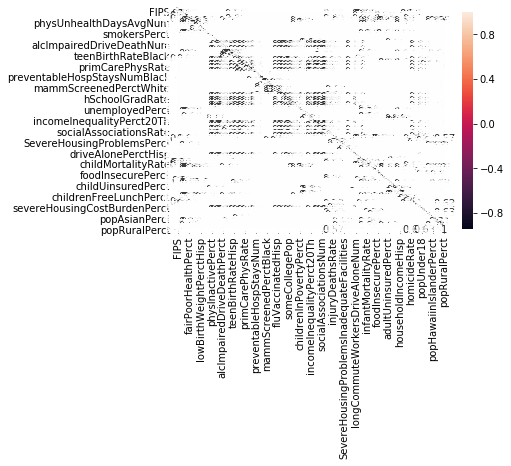

In [12]:
sn.heatmap(corr,annot=True)

In [11]:
hmap